In [21]:
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.stats import pearsonr

In [2]:
tf.random.set_seed(69)
random.seed(69)
np.random.seed(69)

In [3]:
df = pd.read_csv('./data/dailySentiment.csv')
df.head()

,Unnamed: 0,Day,Price,Sentiment
0,4507,20150105,3.22,-0.534077
1,4508,20150106,2.98,-0.337025
2,4509,20150107,3.08,-0.065357
3,4510,20150108,2.92,-0.326590
4,4511,20150109,2.96,-0.374404


In [22]:
pearsonr(df.Price, df.Sentiment)

(-0.18368304970344537, 1.124698550357989e-15)

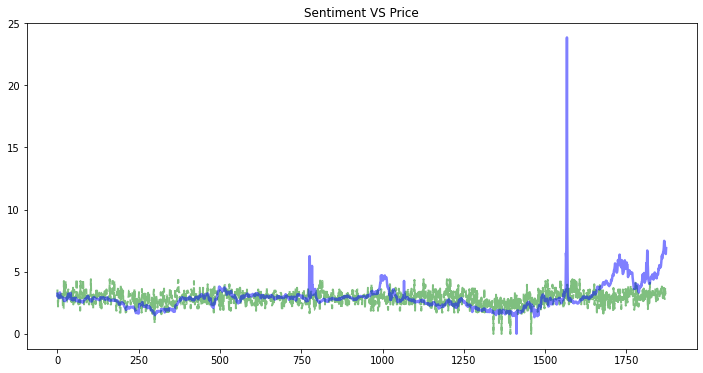

In [4]:
avg = sum(list(df.Price))/len(list(df.Price))
sen = list(df.Sentiment)
price = list(df.Price)
for i in range (len(sen)):
    sen[i] = -(sen[i]*avg)+2
plt.figure(figsize=(12, 6))
l1 = plt.plot(sen, lw = 2, color='green', alpha=0.5, linestyle='dashed')
l2 = plt.plot(price, lw = 2.5, color='blue', alpha=0.5)
plt.title('Sentiment VS Price')
plt.show()

In [5]:
def singleStepSampler(df, window):
    xRes = []
    yRes = []
    for i in range(0, len(df)-window):
        res = []
        for j in range(0, window):
            res.append([df.Price[i+j], df.Sentiment[i+j]])
        res.append([0, df.Sentiment[i+window]])
        xRes.append(res)
        yRes.append(df.Price[i+window])
    tf.convert_to_tensor(xRes)
    return (tf.convert_to_tensor(xRes), tf.convert_to_tensor(yRes))

In [6]:
SPLIT = 0.85
xVal, yVal = singleStepSampler(df, 20)
xTrain = xVal[:int(SPLIT*len(xVal))]
yTrain = yVal[:int(SPLIT*len(yVal))]
xTest = xVal[int(SPLIT*len(xVal)):]
yTest = yVal[int(SPLIT*len(yVal)):]
(xTrain.shape, xTest.shape)

(TensorShape([1575, 21, 2]), TensorShape([278, 21, 2]))

In [7]:
(xTrain[0], yTrain[0])

(<tf.Tensor: shape=(21, 2), dtype=float64, numpy=
 array([[ 3.22      , -0.53407659],
        [ 2.98      , -0.33702523],
        [ 3.08      , -0.06535698],
        [ 2.92      , -0.32659015],
        [ 2.96      , -0.37440371],
        [ 2.9       , -0.28797958],
        [ 2.92      , -0.32659015],
        [ 3.15      , -0.3090599 ],
        [ 3.32      , -0.28900051],
        [ 3.11      , -0.38719366],
        [ 2.94      , -0.35766462],
        [ 2.94      , -0.35766462],
        [ 2.95      , -0.44056478],
        [ 2.96      , -0.37440371],
        [ 2.92      , -0.32659015],
        [ 2.96      , -0.37440371],
        [ 2.89      , -0.39860696],
        [ 2.88      , -0.01438307],
        [ 2.88      , -0.01438307],
        [ 2.88      , -0.01438307],
        [ 0.        , -0.76904183]])>,
 <tf.Tensor: shape=(), dtype=float64, numpy=2.67>)

In [8]:
def smape(y_true, y_pred):
    epsilon = 0.1
    summ = K.maximum(K.abs(y_true) + K.abs(y_pred) + epsilon, 0.5 + epsilon)
    smape = K.abs(y_pred - y_true) / summ * 2.0
    return smape

In [9]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv1D(32, kernel_size=(3), input_shape=(21, 2)))
model.add(tf.keras.layers.MaxPool1D(pool_size=3, strides=(1), padding='valid'))
model.add(tf.keras.layers.LSTM(256, return_sequences=True))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='linear'))
model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(), metrics=['mse', 'mae', smape])

In [12]:
model.fit(xTrain, yTrain, epochs=50)

Epoch 1/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0967 - mse: 0.1673 - mae: 0.0967 - smape: 0.0325
Epoch 2/50
50/50 [==============================] - 0s 8ms/step - loss: 0.1011 - mse: 0.1660 - mae: 0.1011 - smape: 0.0342
Epoch 3/50
50/50 [==============================] - 0s 8ms/step - loss: 0.1018 - mse: 0.1746 - mae: 0.1018 - smape: 0.0346
Epoch 4/50
50/50 [==============================] - 0s 8ms/step - loss: 0.0988 - mse: 0.1843 - mae: 0.0988 - smape: 0.0333
Epoch 5/50
50/50 [==============================] - 0s 8ms/step - loss: 0.0975 - mse: 0.1654 - mae: 0.0975 - smape: 0.0328
Epoch 6/50
50/50 [==============================] - 0s 8ms/step - loss: 0.1003 - mse: 0.1741 - mae: 0.1003 - smape: 0.0340
Epoch 7/50
50/50 [==============================] - 0s 8ms/step - loss: 0.0977 - mse: 0.1745 - mae: 0.0977 - smape: 0.0330
Epoch 8/50
50/50 [==============================] - 0s 8ms/step - loss: 0.0937 - mse: 0.1655 - mae: 0.0937 - smape: 0.0317
Epoch 9/50
50/5

In [14]:
model.evaluate(xTest, yTest)

9/9 [==============================] - 0s 14ms/step - loss: 0.1631 - mse: 0.0583 - mae: 0.1631 - smape: 0.0355


[0.16310197114944458,
 0.058276209980249405,
 0.16310197114944458,
 0.03548961505293846]

In [147]:
data = []
for item in xTest:
    data.append(model.predict(np.array([item])))

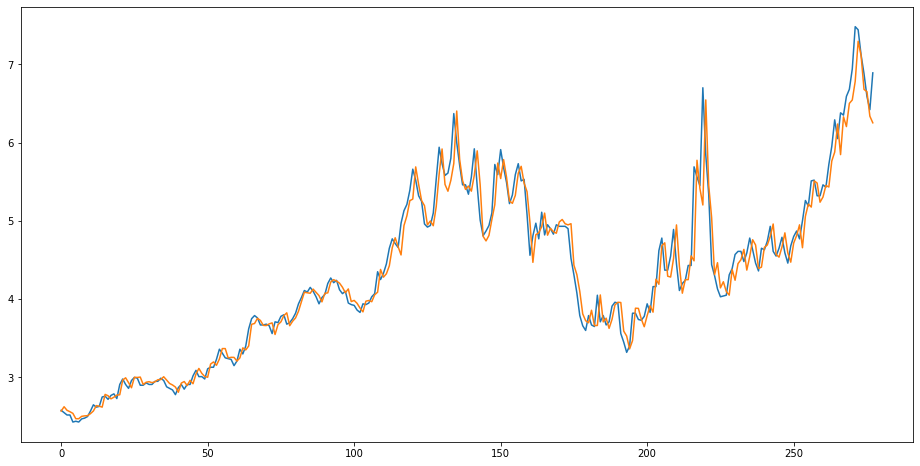

In [148]:
dafr = pd.DataFrame(data={'actual': yTest, 'prediction': [item[0][0] for item in data]})
plt.figure(figsize=(16, 8))
plt.plot(dafr)
plt.show()

In [149]:
model.save('./models/singleStepDailyProposed.h5')

In [ ]:
def multiStepSampler(df, window, door):
    xRes = []
    yRes = []
    for i in range(0, len(df)-window):
        res = []
        for j in range(0, window):
            res.append([df.Price[i+j], df.Sentiment[i+j]])
        res.append([0, df.Sentiment[i+window]])
        xRes.append(res)
        yRes.append(df.Price[i+window])
    tf.convert_to_tensor(xRes)
    return (tf.convert_to_tensor(xRes), tf.convert_to_tensor(yRes))